# Feature Selection

Attempting various techniques for feature selection due to model not having predictive power above baseline and not predicting the minority class very well, even after attempting SMOTE to try and rule out class imbalance as the main reason why the model is not performing.  For details on the class imbalance investigation, including SMOTE and ad-hoc sampling tests, please see the [`07_supplemental`]('07_supplemental.ipynb') notebook.

Some evaluation will be done here, but the various feature selections/configurations are also used in conjunction with other areas in other notebooks, such as the class imbalance investigation section where some of the performance of these various feature configurations are examined with manual class balancing by under sampling the majority class and seeing how scoring changes as the class balance changes.

_NOTE: There could be code blocks that are commented out.  These are included as notes of different outcomes and outputs that were observed. In addition, since it was found that the results may vary each time the code is run, if there is a discrepancy in the visual and the markdown code, that would explain the difference._

# Import Libraries

In [131]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# Read Data

In [132]:
tickets = pd.read_pickle('../data/modeling_data.pkl')

In [133]:
tickets.head(3)

,sat_score,grp_stations,asign_stations,reopens,replies,reply_mins,first_reso_mins,full_reso_mins,agt_wait_mins,reqstr_wait_mins,on_hold_mins,sent_score,num_comms,td_crtd_assnd,td_assnd_slvd,rply_rate,comm_rate
0,0,1,1,0,1,23.0,23,23,0,23,0,0.746100,2,7.0,15.0,0.043478,0.086957
1,0,1,1,0,1,45.0,45,45,0,44,0,0.526767,3,10.0,34.0,0.022222,0.066667
2,0,1,1,0,1,9.0,9,9,0,9,0,0.776250,2,7.0,2.0,0.111111,0.222222


In [134]:
tickets.shape

(13323, 17)

In [135]:
tickets.columns

Index(['sat_score', 'grp_stations', 'asign_stations', 'reopens', 'replies',
       'reply_mins', 'first_reso_mins', 'full_reso_mins', 'agt_wait_mins',
       'reqstr_wait_mins', 'on_hold_mins', 'sent_score', 'num_comms',
       'td_crtd_assnd', 'td_assnd_slvd', 'rply_rate', 'comm_rate'],
      dtype='object')

In [136]:
tickets.dtypes

sat_score             int64
grp_stations          int64
asign_stations        int64
reopens               int64
replies               int64
reply_mins          float64
first_reso_mins       int64
full_reso_mins        int64
agt_wait_mins         int64
reqstr_wait_mins      int64
on_hold_mins          int64
sent_score          float64
num_comms             int64
td_crtd_assnd       float64
td_assnd_slvd       float64
rply_rate           float64
comm_rate           float64
dtype: object

In [137]:
tickets.isna().sum()[tickets.isna().sum() > 0]

Series([], dtype: int64)

In [138]:
tickets['sat_score'].value_counts()

1    11386
0     1937
Name: sat_score, dtype: int64

In [139]:
tickets['sat_score'].value_counts(normalize=True).mul(100).round(2)

1    85.46
0    14.54
Name: sat_score, dtype: float64

# Prepare Data

This section will configure the data to be used for the various feature selection techniques in this notebook

## Configure X, y

In [140]:
# configure X and y that can be reused as needed

X = tickets.drop(columns=['sat_score'])
y = tickets['sat_score']

## Train/Test Split

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2,
                                                   stratify=y,
                                                   random_state=415)

# Import Model(s)

In the various techniques, a model may be required. As some modeling has occurred that led to this more involved feature selection process, any model of interest will be imported here.

In [142]:
with open('../models/rf_nine.pkl', 'rb') as f:
    rf_nine = pickle.load(f)

In [143]:
type(rf_nine)

sklearn.ensemble._forest.RandomForestClassifier

# Results for Comparison

Here, we'll create accuracy scores and metrics for the `rf_nine` model with the full data, so we can use this for comparison with the other selected feature subsets in this notebook.

In [144]:
rf_nine.fit(X_train, y_train)

RandomForestClassifier(max_depth=95, max_features=4, min_samples_leaf=5,
                       n_estimators=175, warm_start=True)

In [145]:
print(
f'CrossVal: {cross_val_score(rf_nine, X_train, y_train).mean().round(3)}\n'
f'Train Score: {rf_nine.score(X_train, y_train).round(3)}\n'
f'Test Score: {rf_nine.score(X_test, y_test).round(3)}\n'
)

CrossVal: 0.855
Train Score: 0.876
Test Score: 0.854



In [146]:
print(classification_report(y_test, rf_nine.predict(X_test)))

              precision    recall  f1-score   support

           0       0.38      0.01      0.02       387
           1       0.86      1.00      0.92      2278

    accuracy                           0.85      2665
   macro avg       0.62      0.50      0.47      2665
weighted avg       0.79      0.85      0.79      2665



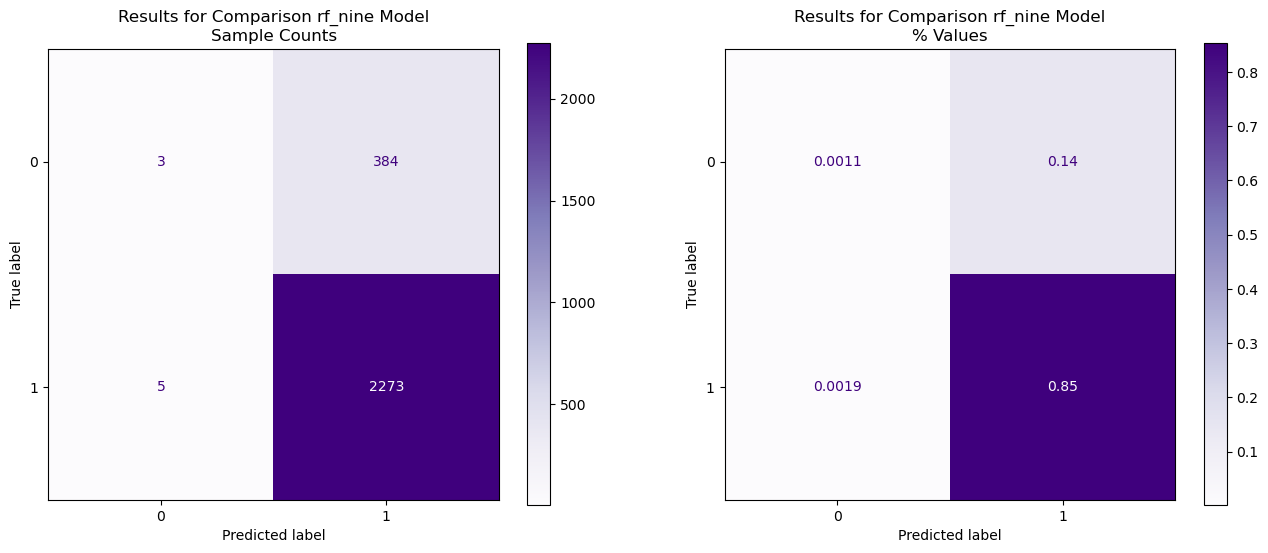

In [147]:
# plot both counts and percentages
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ConfusionMatrixDisplay.from_estimator(rf_nine, 
                                      X_test, 
                                      y_test,
                                      cmap='Purples',
                                      ax=ax1)
ax1.set_title('Results for Comparison rf_nine Model\nSample Counts')

ConfusionMatrixDisplay.from_estimator(rf_nine, 
                                      X_test, 
                                      y_test,
                                      normalize='all',
                                      cmap='Purples',
                                      ax=ax2)
ax2.set_title('Results for Comparison rf_nine Model\n% Values');

These metrics are what have led to trying to select features and improve the model performance.  The overall accuracy is right around the baseline and was done by predicting the majority class in 99% of the observations.  This shows the very poor recall and f1 scores that are also indicativae of the model not being able to predict the minority class.

# Algorithmic Feature Selection

## Tree-based feature selection

Using the `rf_nine` model that was imported, I will fit that with the imbalanced dataset and use some of the features built in to sklearn (SelectFromModel) to see which features this approach deemed appropriate.  

[sklearn reference](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel)

### Use `SelectFromModel`

Here SelectFromModel will use information from the fitted model in order to choose features.  Using that information, the X feature data for both train and test will be transformed and I will evaluate the performance using scoring and classification metrics.

In [148]:
model = SelectFromModel(rf_nine, prefit=True)
X_train_new = model.transform(X_train)
X_test_new = model.transform(X_test)

/Users/matt/miniforge3/envs/tfm1/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/matt/miniforge3/envs/tfm1/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [149]:
# check the features that were fit on the model
rf_nine.feature_names_in_

array(['grp_stations', 'asign_stations', 'reopens', 'replies',
       'reply_mins', 'first_reso_mins', 'full_reso_mins', 'agt_wait_mins',
       'reqstr_wait_mins', 'on_hold_mins', 'sent_score', 'num_comms',
       'td_crtd_assnd', 'td_assnd_slvd', 'rply_rate', 'comm_rate'],
      dtype=object)

In [150]:
# get the feature names selected by the SelectFromModel 
tb_feats = model.get_feature_names_out(rf_nine.feature_names_in_)
tb_feats

array(['reply_mins', 'first_reso_mins', 'full_reso_mins', 'agt_wait_mins',
       'reqstr_wait_mins', 'sent_score', 'td_crtd_assnd', 'td_assnd_slvd',
       'rply_rate', 'comm_rate'], dtype=object)

In [151]:
# find out which features were eliminated:
set(rf_nine.feature_names_in_) - set(tb_feats)

{'asign_stations',
 'grp_stations',
 'num_comms',
 'on_hold_mins',
 'reopens',
 'replies'}

In [152]:
# take a look at X_train_new in DF form for quick visual check to see
# if it only has the selected features
pd.DataFrame(X_train_new,
            columns=model.get_feature_names_out(rf_nine.feature_names_in_)
            ).head(3)

,reply_mins,first_reso_mins,full_reso_mins,agt_wait_mins,reqstr_wait_mins,sent_score,td_crtd_assnd,td_assnd_slvd,rply_rate,comm_rate
0,132238.0,132238.0,132238.0,7233.0,125005.0,0.765367,3888.0,128350.0,0.000000,0.000023
1,416.0,7225.0,7225.0,4125.0,3100.0,0.162300,416.0,6808.0,0.000277,0.000969
2,1215.0,1271.0,1271.0,28.0,1242.0,0.379700,1215.0,55.0,0.002360,0.004721


### Check with Selected Features

In [153]:
# re-import model to re-fit with new data
with open('../models/rf_nine.pkl', 'rb') as f:
    rf_nine = pickle.load(f)

In [154]:
rf_nine.fit(X_train_new, y_train)

RandomForestClassifier(max_depth=95, max_features=4, min_samples_leaf=5,
                       n_estimators=175, warm_start=True)

In [155]:
print(
f'CrossVal: {cross_val_score(rf_nine, X_train_new, y_train).mean().round(3)}\n'
f'Train Score: {rf_nine.score(X_train_new, y_train).round(3)}\n'
f'Test Score: {rf_nine.score(X_test_new, y_test).round(3)}\n'
)

CrossVal: 0.854
Train Score: 0.881
Test Score: 0.853



In [156]:
print(classification_report(y_test, 
                            rf_nine.predict(X_test_new), 
                           ))

              precision    recall  f1-score   support

           0       0.38      0.02      0.03       387
           1       0.86      1.00      0.92      2278

    accuracy                           0.85      2665
   macro avg       0.62      0.51      0.48      2665
weighted avg       0.79      0.85      0.79      2665



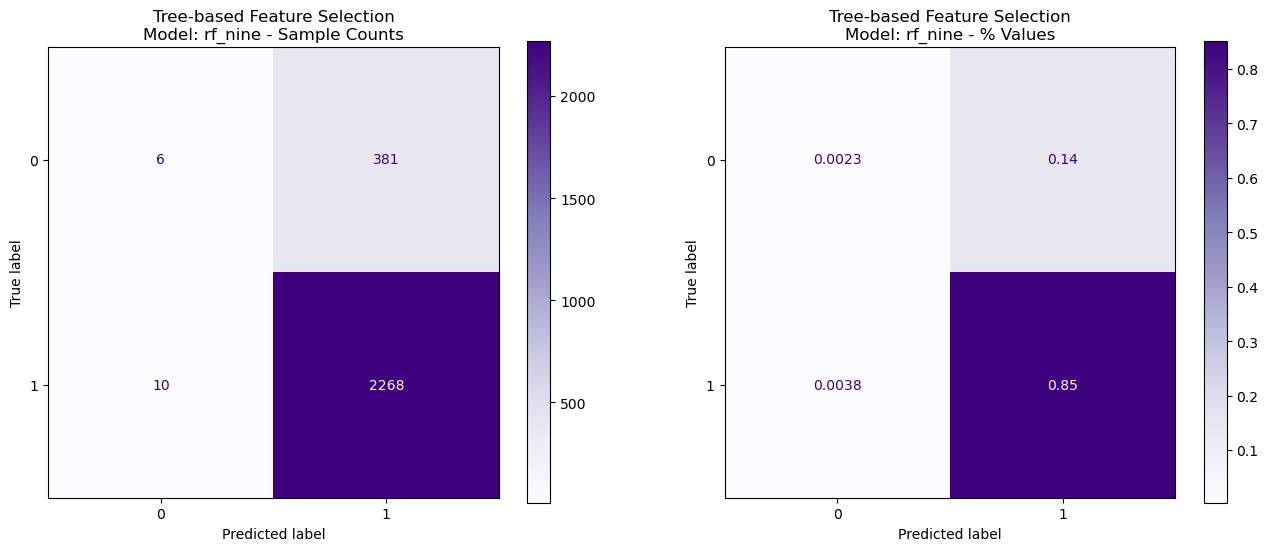

In [157]:
# plot both counts and percentages
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ConfusionMatrixDisplay.from_estimator(rf_nine, 
                                      X_test_new, 
                                      y_test,
                                      cmap='Purples',
                                      ax=ax1)
ax1.set_title('Tree-based Feature Selection\nModel: rf_nine - Sample Counts')

ConfusionMatrixDisplay.from_estimator(rf_nine, 
                                      X_test_new, 
                                      y_test,
                                      normalize='all',
                                      cmap='Purples',
                                      ax=ax2)
ax2.set_title('Tree-based Feature Selection\nModel: rf_nine - % Values');

These results are very similar to the results from the `rf_nine` model.  There were actually fewer true negatives and more false negatives identified in this attempt.

### Tree-based feature selection summary

This techinque led to the elimination of the following features:

```python
{'asign_stations',
 'grp_stations',
 'num_comms',
 'on_hold_mins',
 'reopens',
 'replies'}
```

Which means it kept the following features:
```python
['reply_mins', 'first_reso_mins', 'full_reso_mins', 'agt_wait_mins',
       'reqstr_wait_mins', 'sent_score', 'td_crtd_assnd', 'td_assnd_slvd',
       'rply_rate', 'comm_rate']
```
When the model was fit with just the selected features, it is still suffering from no real predictive power above baseline, and acheiving that score by largely predicting the majority class and not having the ability to predict the minority class.  Although the recall score is the same as our comparison results, the precision actually went down using just these features.

## Recursive Feature Elimination

Using sklearn's `RFECV`, `StratifiedKFold`, and their example, I ran my data through these steps which programmatically checks features, removes one checks again, and so on to find the ideal number of features.

Note: the default metric is accuracy, but in my earlier testing I saw the F1 amd recall swing, so this feature elimination will be run with various scoring metrics.  I will try `F1` as the scoring metric, `balanced_accuracy` which appears to be a metric to help battle issues with class imbalance, and `precision` to see how the overall results may vary. 

Also, as the code was run multiple times, there were some variances in the results.  There are some commented out code blocks below that may have related to those tests.  If a plot was generated for one of those tests, the resulting plot's image was saved in the `assets` directory of this repo, and should be labeled `rfe_<metric>_<no of feats>`.

[Documentation link](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py)

### Scoring Metric: F1

In [158]:
# import model to start clean
with open('../models/rf_nine.pkl', 'rb') as f:
    rf_nine = pickle.load(f)

In [159]:
# Minimum number of features to consider
min_features_to_select = 3  

# configure stratified cross-validator
cv = StratifiedKFold(5) 

# configure the recursive feature elimination with cross-validation
rfecv = RFECV(
    estimator=rf_nine,
    step=1,
    cv=cv,
    scoring="f1",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 16


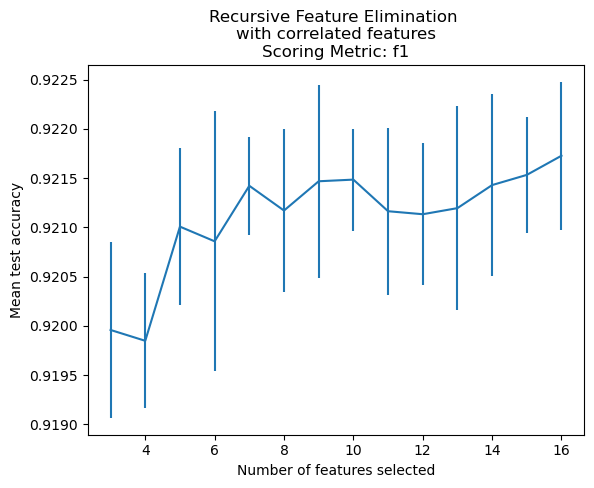

In [160]:
# the last result I had was for 12 features.  If this notebook is run and 
# there is a different result, you can find the plot for 12 features in 
# the assets directory of this repo

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features\n\
Scoring Metric: f1")
plt.show()

In [161]:
# look at the ranking results
pd.DataFrame(rfecv.ranking_, rfecv.feature_names_in_).sort_values(by=0)

# results for 12 features
# replies 	1
# reply_mins 	1
# first_reso_mins 	1
# full_reso_mins 	1
# agt_wait_mins 	1
# reqstr_wait_mins 	1
# sent_score 	1
# num_comms 	1
# td_crtd_assnd 	1
# td_assnd_slvd 	1
# rply_rate 	1
# comm_rate 	1
# grp_stations 	2
# reopens 	3
# asign_stations 	4
# on_hold_mins 	5

,0
grp_stations,1
asign_stations,1
reopens,1
replies,1
reply_mins,1
first_reso_mins,1
full_reso_mins,1
agt_wait_mins,1
reqstr_wait_mins,1
on_hold_mins,1


According to the documentation, only features with a "1" value are the ones considered important.

In [162]:
rfe_f1_12_feats = rfecv.get_feature_names_out()
#['replies','reply_mins','first_reso_mins','full_reso_mins',
#'agt_wait_mins','reqstr_wait_mins','sent_score','num_comms',
#'td_crtd_assnd','td_assnd_slvd','rply_rate','comm_rate']

Below is an interesting result that was found while re-running this section of the notebook a few times.  At one point, this process identified 10 features as optimal.

In [163]:
# time when it found 10 features and not 15
# plot is stored in assets directory

# n_scores = len(rfecv.cv_results_["mean_test_score"])
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Mean test accuracy")
# plt.errorbar(
#     range(min_features_to_select, n_scores + min_features_to_select),
#     rfecv.cv_results_["mean_test_score"],
#     yerr=rfecv.cv_results_["std_test_score"],
# )
# plt.title("Recursive Feature Elimination \nwith correlated features\n\
# Scoring Metric: f1")
# plt.show()

In [164]:
# look at the ranking results `10 features
# pd.DataFrame(rfecv.ranking_, rfecv.feature_names_in_).sort_values(by=0)

# reply_mins 	1
# first_reso_mins 	1
# full_reso_mins 	1
# agt_wait_mins 	1
# reqstr_wait_mins 	1
# sent_score 	1
# td_crtd_assnd 	1
# td_assnd_slvd 	1
# rply_rate 	1
# comm_rate 	1
# num_comms 	2
# replies 	3
# grp_stations 	4
# reopens 	5
# asign_stations 	6
# on_hold_mins 	7

In [165]:
# extract the selected features time when it chose 10
# rfecv.get_feature_names_out()
# ['reply_mins', 'first_reso_mins', 'full_reso_mins', 'agt_wait_mins',
#        'reqstr_wait_mins', 'sent_score', 'td_crtd_assnd', 'td_assnd_slvd',
#        'rply_rate', 'comm_rate']

In [166]:
rfe_f1_10_feats = ['reply_mins', 'first_reso_mins', 'full_reso_mins', 'agt_wait_mins',
       'reqstr_wait_mins', 'sent_score', 'td_crtd_assnd', 'td_assnd_slvd',
       'rply_rate', 'comm_rate']

In [167]:
# check if the values of the tree-based method and the rfe 10 are the same
set(tb_feats) == set(rfe_f1_10_feats)

True

It appears that when the RFE identified 10 features, it was the same set of featres that the tree-based approach found.

Beyond the results above, there was one instance where it identified 15 features, suggesting that the `on_hold_mins` feature is not as important as the others for modeling.

### Scoring Metric: balanced_accuracy

In [168]:
# import model to start clean
with open('../models/rf_nine.pkl', 'rb') as f:
    rf_nine = pickle.load(f)

In [169]:
# Minimum number of features to consider
min_features_to_select = 3  

# configure stratified cross-validator
cv = StratifiedKFold(5) 

# configure the recursive feature elimination with cross-validation
rfecv = RFECV(
    estimator=rf_nine,
    step=1,
    cv=cv,
    scoring="balanced_accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)
rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 9


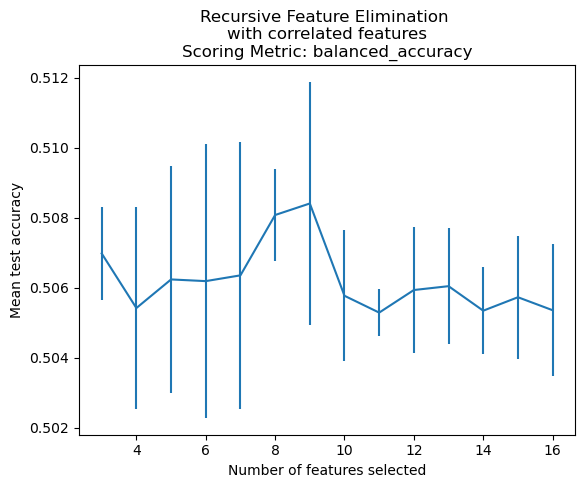

In [170]:
# last result was 8 features
# if notebook is run and the result changes, the 8 feature plot can be 
# found in the assets directory of this repo

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features\n\
Scoring Metric: balanced_accuracy")
plt.show()

In [171]:
# rfe_bal_8_feats = rfecv.get_feature_names_out()
# ['reply_mins', 'first_reso_mins', 'full_reso_mins',
#        'reqstr_wait_mins', 'sent_score', 'td_crtd_assnd', 'rply_rate',
#        'comm_rate']

In [172]:
# # when result was 10 features
# n_scores = len(rfecv.cv_results_["mean_test_score"])
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Mean test accuracy")
# plt.errorbar(
#     range(min_features_to_select, n_scores + min_features_to_select),
#     rfecv.cv_results_["mean_test_score"],
#     yerr=rfecv.cv_results_["std_test_score"],
# )
# plt.title("Recursive Feature Elimination \nwith correlated features\n\
# Scoring Metric: balanced_accuracy")
# plt.show()

In [173]:
# rfe_bal_10_feats = rfecv.get_feature_names_out()
#['reply_mins', 'first_reso_mins', 'full_reso_mins', 'agt_wait_mins',
       # 'reqstr_wait_mins', 'sent_score', 'td_crtd_assnd', 'td_assnd_slvd',
       # 'rply_rate', 'comm_rate']

In [174]:
# rfe_bal_10_feats

In [175]:
# # when result was 9 features
# n_scores = len(rfecv.cv_results_["mean_test_score"])
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Mean test accuracy")
# plt.errorbar(
#     range(min_features_to_select, n_scores + min_features_to_select),
#     rfecv.cv_results_["mean_test_score"],
#     yerr=rfecv.cv_results_["std_test_score"],
# )
# plt.title("Recursive Feature Elimination \nwith correlated features\n\
# Scoring Metric: balanced_accuracy")
# plt.show()

In [176]:
# look at the ranking results
pd.DataFrame(rfecv.ranking_, rfecv.feature_names_in_).sort_values(by=0)

,0
reply_mins,1
first_reso_mins,1
full_reso_mins,1
reqstr_wait_mins,1
sent_score,1
td_crtd_assnd,1
td_assnd_slvd,1
rply_rate,1
comm_rate,1
agt_wait_mins,2


In [177]:
# rfe_bal_9_feats = rfecv.get_feature_names_out()
# ['reply_mins', 'first_reso_mins', 'full_reso_mins',
#        'reqstr_wait_mins', 'sent_score', 'td_crtd_assnd', 'td_assnd_slvd',
#        'rply_rate', 'comm_rate']

In [178]:
# rfe_bal_9_feats

In [179]:
# rfe_bal_8_feats

Although I saw some variance in how many features this method chose (8, 9, 10) when I look at the various charts the overall variance in the balanced accuracy score is quite small--meaning the worst score on the plot is ~0.504 and the highest is ~0.508, so even though the plots may look quite different, the values are quite close to each other.

### Scoring Metric: Precision

In [180]:
# import model to start clean
with open('../models/rf_nine.pkl', 'rb') as f:
    rf_nine = pickle.load(f)

In [181]:
# Minimum number of features to consider
min_features_to_select = 3  

# configure stratified cross-validator
cv = StratifiedKFold(5) 

# configure the recursive feature elimination with cross-validation
rfecv = RFECV(
    estimator=rf_nine,
    step=1,
    cv=cv,
    scoring="precision",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)
rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 3


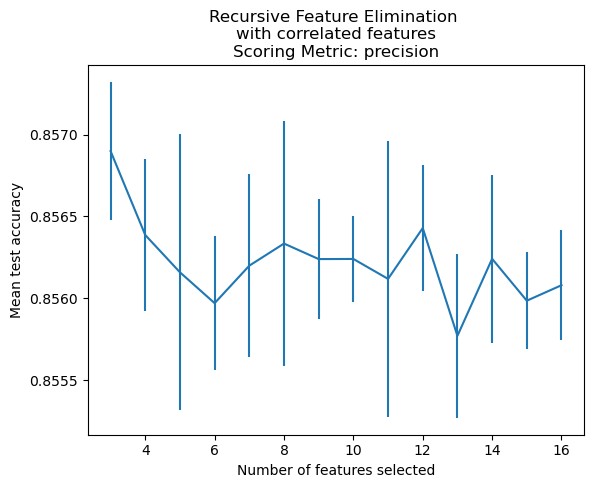

In [182]:
# last result was 10 features
# if notebook is run and the result changes, the 10 feature plot can be 
# found in the assets directory of this repo

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features\n\
Scoring Metric: precision")
plt.show()

In [183]:
# rfe_prec_10_feats = rfecv.get_feature_names_out()

In [184]:
# when result was 7 features
# n_scores = len(rfecv.cv_results_["mean_test_score"])
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Mean test accuracy")
# plt.errorbar(
#     range(min_features_to_select, n_scores + min_features_to_select),
#     rfecv.cv_results_["mean_test_score"],
#     yerr=rfecv.cv_results_["std_test_score"],
# )
# plt.title("Recursive Feature Elimination \nwith correlated features\n\
# Scoring Metric: precision")
# plt.show()

In [185]:
# rfe_prec_7_feats = rfecv.get_feature_names_out()

In [186]:
# # when result was 8 features
# n_scores = len(rfecv.cv_results_["mean_test_score"])
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Mean test accuracy")
# plt.errorbar(
#     range(min_features_to_select, n_scores + min_features_to_select),
#     rfecv.cv_results_["mean_test_score"],
#     yerr=rfecv.cv_results_["std_test_score"],
# )
# plt.title("Recursive Feature Elimination \nwith correlated features\n\
# Scoring Metric: precision")
# plt.show()

In [187]:
# second instance where I saw 8 features
# rfe_prec_8_feats_2 = rfecv.get_feature_names_out()
# ['reply_mins', 'first_reso_mins', 'full_reso_mins',
#         'reqstr_wait_mins', 'sent_score', 'td_crtd_assnd', 'rply_rate',
#         'comm_rate']

In [188]:
# rfe_prec_8_feats = rfecv.get_feature_names_out()
# ['reply_mins', 'first_reso_mins', 'full_reso_mins',
#         'reqstr_wait_mins', 'sent_score', 'td_crtd_assnd', 'rply_rate',
#         'comm_rate']

In [189]:
# set(rfe_bal_10_feats) == set(rfe_prec_10_feats) == set(rfe_f1_10_feats)
# result was True
# so regarless of the metric, eat identified set of 10 features were the same

In [190]:
# check to see if the rfe 10 features are the same as the tree based 10
# set(rfe_bal_10_feats) == set(tb_feats)
# result was True

Although there was variance in how many features were selected in each of the metrics, I do see that each of them had, at one point, selected 10 features as optimal.  Above, I checked to see if all sets of 10 features chosen by the three different metrics were the same, meaning there was some consensus that these were the 10 optimal features and that appears to the be the case.  As such, these 10 features would be the ones that I used to generate a classification report and confusion matrix for comparison, but since they are also equal to the 10 chosen by the tree-based approach, we already have that data for comparison.

### RFE Summary

When using different metrics like `F1`, `balanced_accuracy`, or `precision`, the results varied if I ran the same code multiple times.  For the `F1` results it could swing a bit from 15 to 10 features, the `balanced_accuracy` seemed to oscillate between 9 and 10 features, and `precision` had results between 7 to 10 features.  Since this is using a cross-validator, I think this could be indicating that the model is quite sensitive to the data that is being used which is creating enough variability that the results are varying like this.  

Although you can see the different scores on different plots between the different attempts with the same code, overall the range of scoring metrics per plot is quite small. For example, on the F1 plots, even when you look at the plot for 10 features vs. the plot for 15 features, the changes may look drastic, but the y-axis range for results is ~0.919 to ~0.925, which is quite small.  Likewise on the balanced_accuracy metric plots, we see a range from ~0.504 to ~0.508.  For precision we see ~0.855 to ~0.857--again, not a huge range.

Looking at what is most common between all of these might give us the best results, but for now, I'll store these results so they can be accessed later if needed.

## Univariate feature selection

Another approach from scikit learn, is using `SelectKBest` for univariate feature selection.  Compared to the other approaches above, this one only has variability based on how many features you want to select (k value) since it is using univariate statistical tests for calculation.  You can then plot the scores for all the features, and choose the features based on the highest scores.  If you set a k value it will just choose the k highest scores.

[scikit learn documentation](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)

In [191]:
# adapted from the documentation exmaple
selector = SelectKBest(f_classif)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

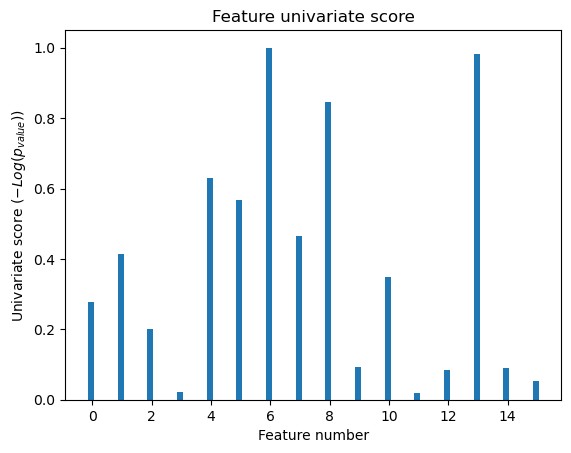

In [192]:
# adapted from the documentation exmaple
X_indices = np.arange(X.shape[-1])
plt.figure(1)
plt.clf()
plt.bar(X_indices - 0.05, scores, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.show()

The higher values in the plot above would indicate the more important features. And the feature number is the index in the X_train columns list:

In [193]:
X_train.columns

Index(['grp_stations', 'asign_stations', 'reopens', 'replies', 'reply_mins',
       'first_reso_mins', 'full_reso_mins', 'agt_wait_mins',
       'reqstr_wait_mins', 'on_hold_mins', 'sent_score', 'num_comms',
       'td_crtd_assnd', 'td_assnd_slvd', 'rply_rate', 'comm_rate'],
      dtype='object')

For example, the highest bar is for feature index 6, which relates to the `full_reso_mins` feature.

In [194]:
#k=10: ['grp_stations', 'asign_stations', 'reopens', 'reply_mins',
       # 'first_reso_mins', 'full_reso_mins', 'agt_wait_mins',
       # 'reqstr_wait_mins', 'sent_score', 'td_assnd_slvd']
        
# k=4: ['reply_mins', 'full_reso_mins', 'reqstr_wait_mins', 'td_assnd_slvd']
        
selector.get_feature_names_out()

array(['grp_stations', 'asign_stations', 'reopens', 'reply_mins',
       'first_reso_mins', 'full_reso_mins', 'agt_wait_mins',
       'reqstr_wait_mins', 'sent_score', 'td_assnd_slvd'], dtype=object)

Check the `k=10` value to see if the same 10 features here are equivalent to the 10 feature sets from RFE and Tree-based selection.  We do know that the tree-based features `tb_feats` is equivalent to the 10 selected RFE features:

In [195]:
set(list(selector.get_feature_names_out())) ==\
set(tb_feats)

False

In [196]:
# since these are not equivalent, store these features
k10_feats = list(selector.get_feature_names_out())

It looks like there is a difference here.  Investigate the results:

In [197]:
# what features are in common between k=10 and rfe/tb approaches
set(k10_feats).intersection(set(tb_feats))

# {'agt_wait_mins',
#  'first_reso_mins',
#  'full_reso_mins',
#  'reply_mins',
#  'reqstr_wait_mins',
#  'sent_score',
#  'td_assnd_slvd'}

{'agt_wait_mins',
 'first_reso_mins',
 'full_reso_mins',
 'reply_mins',
 'reqstr_wait_mins',
 'sent_score',
 'td_assnd_slvd'}

Which features are only in the `k=10` set and not in the tb/rfe results:

In [198]:
set(k10_feats) - set(tb_feats)

#{'asign_stations', 'grp_stations', 'reopens'}

{'asign_stations', 'grp_stations', 'reopens'}

In [199]:
# features from the superset that are exlcuded from k=10
set(X_train.columns) - set(k10_feats)

# {'comm_rate',
#  'num_comms',
#  'on_hold_mins',
#  'replies',
#  'rply_rate',
#  'td_crtd_assnd'}

{'comm_rate',
 'num_comms',
 'on_hold_mins',
 'replies',
 'rply_rate',
 'td_crtd_assnd'}

In [200]:
# features from the superset that are exlcuded tb_feats/RFE_10
set(X_train.columns) - set(tb_feats)

# {'asign_stations',
#  'grp_stations',
#  'num_comms',
#  'on_hold_mins',
#  'reopens',
#  'replies'}

{'asign_stations',
 'grp_stations',
 'num_comms',
 'on_hold_mins',
 'reopens',
 'replies'}

In [201]:
# eliminated features in common
(set(X_train.columns) 
 - set(k10_feats)
).intersection(set(X_train.columns) - set(tb_feats))

# {'num_comms', 'on_hold_mins', 'replies'}

{'num_comms', 'on_hold_mins', 'replies'}

In [202]:
# feature set if I remove the common eliminated features
feats_common_eliminated =\
list(set(X_train.columns) - {'num_comms', 'on_hold_mins', 'replies'})

## Export Selected Features

Please note as the below data was not programmatically repeatable, I will comment out the code as to not overwrite the feature data that was initially captured.

In [130]:
# with open('../data/select_10_feats.pkl', 'wb') as f:
#     pickle.dump(tb_feats, f)

# with open('../data/select_12_feats.pkl', 'wb') as f:
#     pickle.dump(rfe_f1_12_feats, f)

# with open('../data/k10_feats.pkl', 'wb') as f:
#     pickle.dump(k10_feats, f)
    
# with open('../data/feats_common_eliminated.pkl', 'wb') as f:
#     pickle.dump(feats_common_eliminated, f)

## Algorithmic Feature Selection Summary

The results from this process have been interesting.  Some key findings:
* Although the RFE approach had the characteristic of providing different results after running the same code, there was consensus with the tree-based method's 10 features.
* The univariate method when `k=10`, which is the default, but also the number I would have selected when visually inspecting the related plot, identified different features, 7 of them in common with the RFE/tree-based 10.
    * Both of the "rate" features that I engineered were eliminated in the univariate method
* Because I've seen so much variation when running RFE, it feels like that is indicating that the underlying data is still the most likely issue for any models that will be produced.  It's still worthwhile to try, but I am suspicious that the resulting models will still perform in a similar manner.

From the work in this notebook, I have identified different sets of features that might be used for modeling to see which ones might perform the best, time-permitting.  Here is the order that I will approach them:
1. `select_10_feats.pkl` - the 10 features that had consensus between tree-based and RFE
2. `k10_feats.pkl` - the 10 features that were identified by the univariate selection method
3. `feats_common_eliminated.pkl` - feature list that excludes features that were eliminated by tree-based, rfe 10, and k10

All three of these approaches, although different, had consensus around 10 features.  This leads me to believe that these are the 10 features that should be used for modeling, since these methods were evaluating the features that were in the data, in addition to the time delta features that I engineered.  

The features that were exlcuded:
* `num_comms`
* `on_hold_mins`
* `replies`

Overall, from my knoweldge of these metrics and the internal workings of the company from which this data was sourced, some of these make sense that they were not found to have importance.  On hold mins can be very workflow dependent and there aren't strict internal process controls around these.  It is actually derived from an "on-hold" ticket status, which is a manual step that not all agents use and is often used only for tickets that relate to bugs, which are more ran than typical tickets.

The number of comments, which was calculated during data cleaning, and replies do represent similar but different data.  Replies is the number of public replies added to the ticket by an agent, whereas the number of comments would include the customer and the agent comments both public and private. I would have suspected that one of these may be of importance, so this is an interesting insight.